In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

# Why does aiming away from the flag work?

Author: William Knauth

Let's take a dive into some interesting probabilistic behavior of shot patterns, and why that allows us to play conservatively into greens without destroying our chances of making birdie.

The plan is to use shot simulation and calculate some metrics. For that, we'll need a strokes gained (SG) baseline for putting. 

## Relevant definitions and formulas

$X$: Horizontal shot displacement

$Y$: Depth shot displacement

$\vec{X} = (X \,\,\, Y)^T$

${\Sigma} = \text{Cov}({\vec{X}})$

$f_{\vec{X}}(\vec{x}) = |2\pi{\Sigma}|^{-\frac12} e^{-\frac12((\vec{x} - \vec{\mu})^T{\Sigma}^{-1}(\vec{x} - \vec{\mu}))}$

$D = \sqrt{X^2 + Y^2}$: Proximity to hole

$S = \text{SG Baseline}(D)$: Strokes gained expectation

$T$: Target displacement

#### We will make:

Histograms approximate $f_{D|T=t}(x)$ and $f_{S|T=t}(x)$

Sensitivity graphs approximate $g(t) = E[D|T=t], h(t) = E[S|T=t]$, and similarly for medians.

#### Note:


We use ${\Sigma} = \sigma I$ where $I$ is the identity matrix to make a circular shot pattern and $\vec{\mu} = (T \,\,\, 0)^T$ to define the target when sampling from the distribution. Rotational symmetry means we may pick any axis to shift the target along, which is the point of approximating with a circular pattern.


# SG Putting Baseline Approximation

The following is a decent approximation. It is by no means perfect, but it is qualitatively similar and close in value for reasonable lengths of putt. 

Most importantly, it has the properties that it is increasing and concave on $[1, \infty)$, meaning that it increases rapidly at first and then tapers off (but still increases forever). This ensures the correct behavior of all of the distributions mathematically.

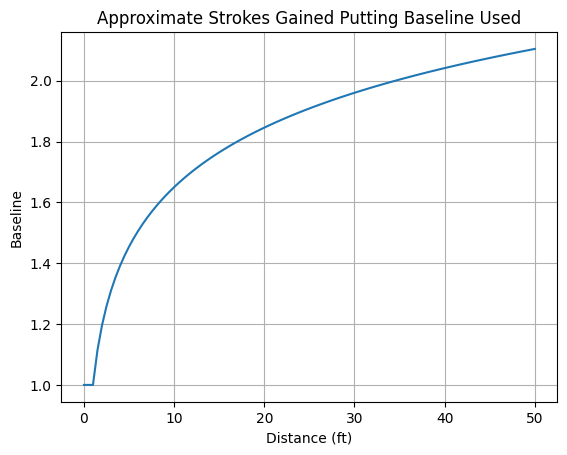

In [2]:
def SGP_array(x):
    flag = x <= 1
    preds = np.zeros(x.shape)
    preds[flag] = 1
    preds[~flag] = 1 + 0.65*np.log10(x[~flag])
    return preds
    
x = np.linspace(0, 50, num=101)
plt.plot(x, SGP_array(x))
plt.title('Approximate Strokes Gained Putting Baseline Used')
plt.xlabel('Distance (ft)')
plt.ylabel('Baseline')
plt.grid()
plt.show()

# Simulation and Distribution Plots

We will assume an infinite green and a circular shot pattern (defaulted to about the size of a tour player's short iron). The shot pattern assumption is actually a solid approximation for these purposes, and allows radial symmetry that exponentially reduces the complexity of the coming information. The infinite green assumption allows us to strip away golf course features, which can be added back into consideration later.

I have the code randomly sampling from a bivariate normal distribution many times, calculating the distance of each shot to the hole, and calculating the SG baseline of the result. We have histograms showing the resulting distributions.

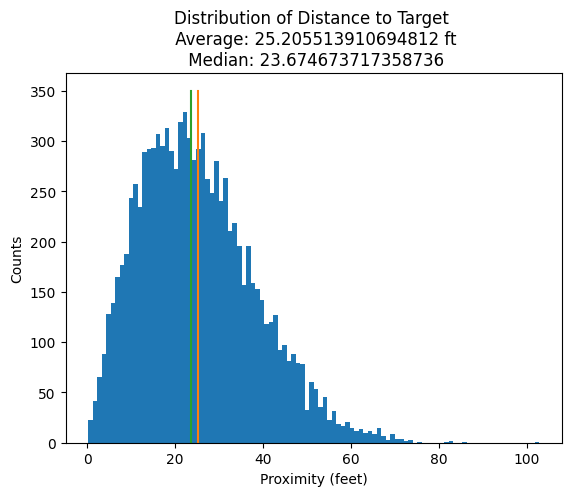

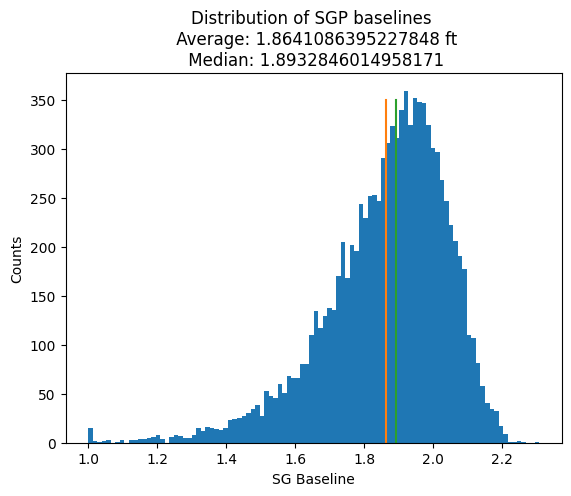

In [3]:
def shot_simulation(mu=None, cov=None, n=10000, var=20):
    if type(mu) == type(None):
        mu = np.zeros((2,))
    if type(cov) == type(None):
        cov = var**2*np.identity(2)
    return np.random.multivariate_normal(mu, cov, size=n)

def get_prox(shots):
    return np.sqrt(shots[:, 0]**2 + shots[:, 1]**2)

prox = get_prox(shot_simulation())
mean = np.mean(prox)
median = np.median(prox)
plt.hist(prox, bins=100)
plt.plot([mean, mean], [0, 350])
plt.plot([median, median], [0, 350])
plt.title('Distribution of Distance to Target \n Average: ' + str(mean) + ' ft\n Median: ' + str(median))
plt.xlabel('Proximity (feet)')
plt.ylabel('Counts')
plt.show()

strokes = SGP_array(prox)
mean = np.mean(strokes)
median = np.median(strokes)
plt.hist(strokes, bins=100)
plt.plot([mean, mean], [0, 350])
plt.plot([median, median], [0, 350])
plt.title('Distribution of SGP baselines \n Average: ' + str(mean) + ' ft\n Median: ' + str(median))
plt.xlabel('SG Baseline')
plt.ylabel('Counts')
plt.show()

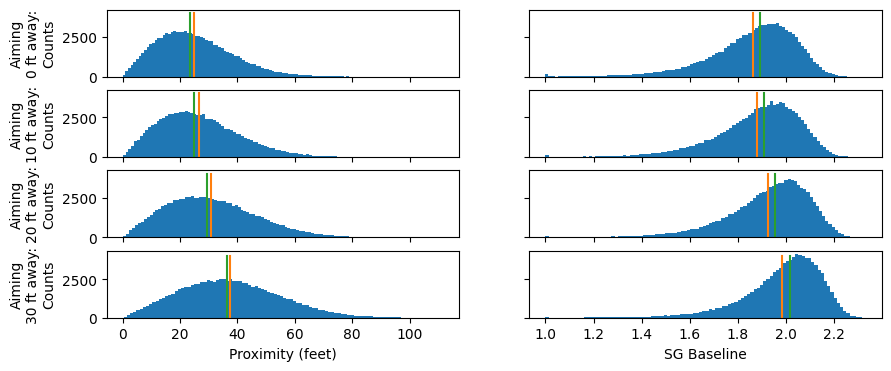

In [4]:
def run_targets(mu=None, cov=None, n=100000, var=20):
    fig, ax = plt.subplots(nrows=4, ncols=2, sharex='col', sharey='row', figsize=(10, 4))
    for i, target in enumerate([0, 10, 20, 30]):
        mu = np.array([target, 0])
        prox = get_prox(shot_simulation(mu=mu, cov=cov, n=n, var=var))
        mean = np.mean(prox)
        median = np.median(prox)
        ax[i, 0].hist(prox, bins=100)
        ax[i, 0].plot([mean, mean], [0, 4000])
        ax[i, 0].plot([median, median], [0, 4000])
        if i == 3:
            ax[i, 0].set_xlabel('Proximity (feet)')
        ax[i, 0].set_ylabel('Aiming\n'+str(target)+' ft away:\nCounts')

        strokes = SGP_array(prox)
        mean = np.mean(strokes)
        median = np.median(strokes)
        ax[i, 1].hist(strokes, bins=100)
        ax[i, 1].plot([mean, mean], [0, 4000])
        ax[i, 1].plot([median, median], [0, 4000])
        if i == 3:
            ax[i, 1].set_xlabel('SG Baseline')
    plt.show()
    
run_targets(var=20)

The above plots are simply the same plots as the previous, just repeated for different targets down columns.

# Sensitivity Graphs

These plots use the simulated distributions to calculate mean and median proximities and baselines for a range of targets to show the relationship between shifting the target and the resulting shift in outcomes. This relationship is not linear, which is ultimately what makes target selection counterintuitive.

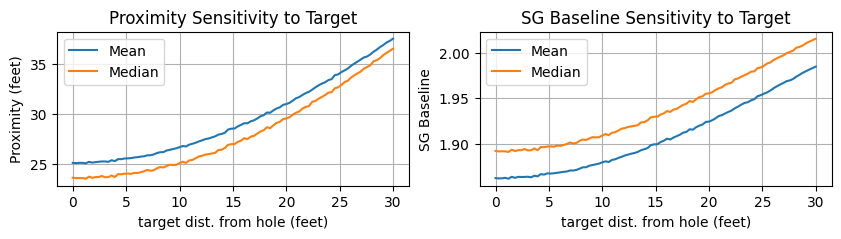

In [5]:
def expectation_sensitivity(target_range, cov=None, n=100000, num_steps=100, var=20):
    r = np.linspace(0, target_range, num=num_steps)
    dist_mean = []
    dist_median = []
    s_mean = []
    s_median = []
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))
    for target in r:
        mu = np.array([target, 0])
        prox = get_prox(shot_simulation(mu=mu, cov=cov, n=n, var=var))
        dist_mean.append(np.mean(prox))
        dist_median.append(np.median(prox))

        strokes = SGP_array(prox)
        s_mean.append(np.mean(strokes))
        s_median.append(np.median(strokes))
        
    ax[0].plot(r, dist_mean)
    ax[0].plot(r, dist_median)
    ax[0].legend(('Mean', 'Median'))
    ax[0].set_title('Proximity Sensitivity to Target')
    ax[0].set_xlabel('target dist. from hole (feet)')
    ax[0].set_ylabel('Proximity (feet)')
    ax[0].grid()
    
    ax[1].plot(r, s_mean)
    ax[1].plot(r, s_median)
    ax[1].legend(('Mean', 'Median'))
    ax[1].set_title('SG Baseline Sensitivity to Target')
    ax[1].set_xlabel('target dist. from hole (feet)')
    ax[1].set_ylabel('SG Baseline')
    ax[1].grid()
    plt.show()

expectation_sensitivity(30, var=20)

# Analysis with different shot pattern sizes

We will now investigate the relationship of shot pattern size to how target affects scoring. Remember, this is all done with circular shot patterns and infinite greens, just to demonstrate the character of the effects.

We will calculate the relationship of mean and median proximity to target offset as well as the mean and median SG baseline to target offset relationship. Then, we will look at distributions for proximity and basline outcomes at a few landmark target offset values.

NOTE: Remember this is an absolute worst-case study for aiming away from pins, since shots are not penalized for missing the green. Therefore the curves on the sensitivity graphs will always increase with this setup, but the key is observing the changes in how much when we adjust the shot patterns and use different targets, and weighing that against risks that come into play on a real golf course.

## STDEV of 5 ft

Imagine this as some sort of around the green shot. This is a very tight shot pattern, and is unrealistic with a shot of any length, but it is a good place to start to get some intuition for how these ideas play with each other.

Aiming at the hole, we have an average proximity around 7 ft and a SG expectation around 1.5, and the distributions are skewed. This behavior is very common as we will see.

Aiming 10 ft away from the hole, we already see a significant increase (bad) in expectation and the skew starting to disappear. This is a sign that we are starting to aim too far from the hole.

At 20 and 30 ft, we have nearly unskewed distributions. If we aim 20 ft away, most of our shots end up 10-30 ft away, and if we aim 30 ft away, most of our shots end up 20-40 ft away. 

By aiming 20 ft away, we increase proximity by 15 ft and increase SG baseline by nearly 0.4. That is a huge difference! This makes sense, just like how we would never aim 20 ft away on a chip shot.

This is what many people intuitively think happens when we aim away from the hole, because we do not instinctively comprehend the size of our shot patterns. We tend to think of them as being more like this 5 ft distribution, not the ones that come later. As we will see, the behavior changes drastically.

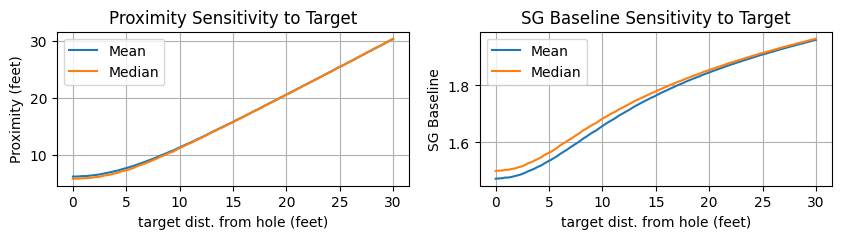

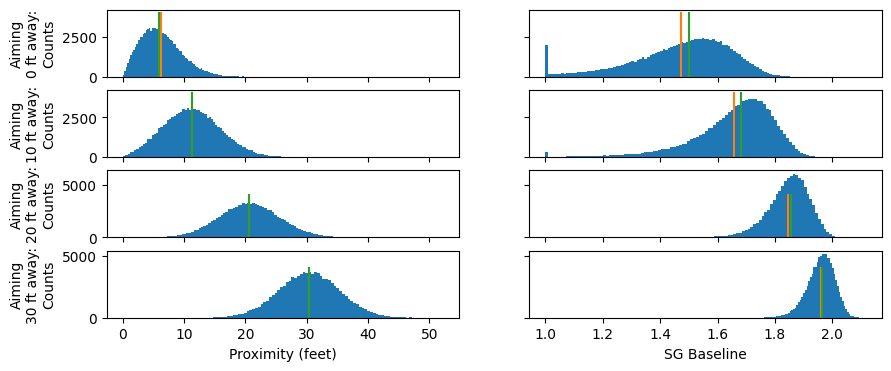

In [6]:
var = 5
expectation_sensitivity(30, var=var)
run_targets(var=var)

## STDEV of 10 ft

At 10 ft standard deviation, this might be a long pitch shot or partial wedge shot for a tour player.

All of the sudden, we begin to see that aiming 10 ft from the hole does not change the distributions much, and only elevates expectation slightly. So, it becomes a viable option to start thinking of aiming slightly away from the hole if there is excess risk on one side. However, at 20 and 30 ft, we still see the skew beginning to disappear and the distributions/expectations move significantly.

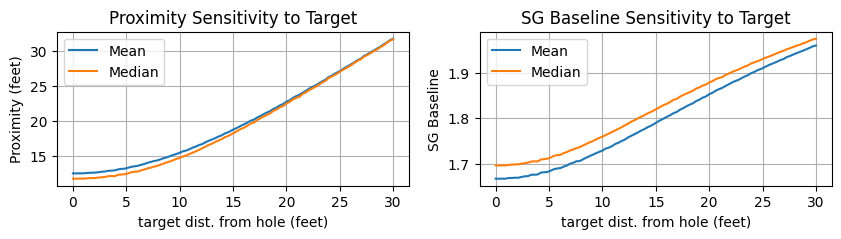

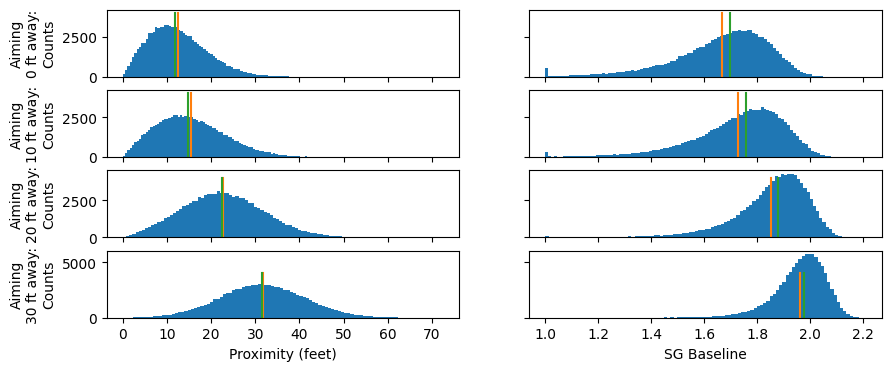

In [7]:
var = 10
expectation_sensitivity(30, var=var)
run_targets(var=var)

## STDEV of 20 ft

This shot pattern might be a short iron for a tour player, a realistic number to use for understanding normal approach target analysis.

Now, we really begin to understand why it is that aiming away from flags works. 

We can aim 10 ft away from the hole, and the distributions look nearly the same, while our average proximity has only increased by 2 ft and our average SG baseline has only increased by 0.03.

We can aim 20 ft away from the hole, and the distributions look nearly the same, while our average proximity has only increased by 6 ft and our average SG baseline has only increased by 0.07. 

That's right--in this model, if we can reduce at least 0.07 shots worth of missed green risk by aiming 20 ft away from the hole, then that is more than enough to make up for the slight increase in putt length you'll face. For context, if you can reduce your chances of landing in the water from 10% to 5%, that would pretty much cover this difference.

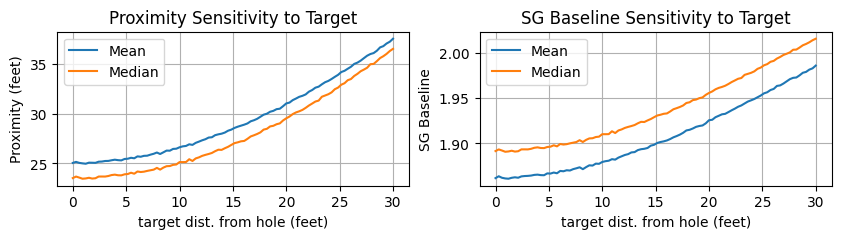

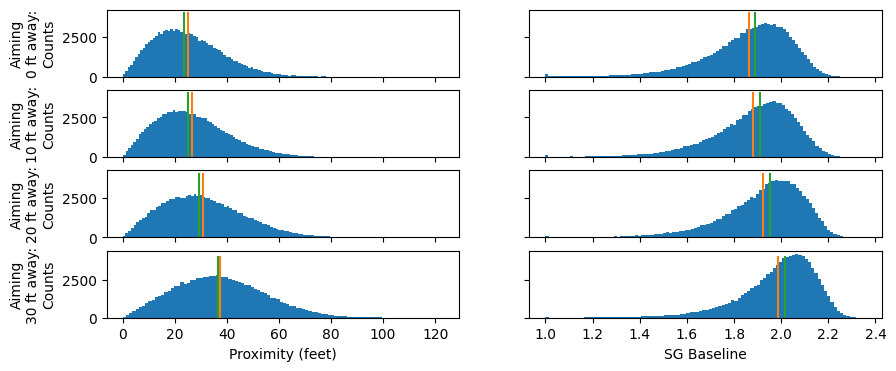

In [8]:
var = 20
expectation_sensitivity(30, var=var)
run_targets(var=var)

## STDEV of 40 ft

For good measure, let's see what happens when your shot pattern is bigger, like the size of a long approach shot.

Comparing distributions, you almost cannot see a difference in proximity or scoring based on moving the target up to 30 ft from the hole.

Let me repeat, because this is an important idea to understand and accept, in order to become comfortable aiming away from flagsticks and remaining patient.

Even with no trouble. Even with an infinitely sized green. Under ideal conditions. You can aim at the flag, or you can aim 30 ft from the hole, and it makes almost no difference in terms of the proximity and scoring outcomes you will see.

With large shot patterns, what does still change when you move the target is whether or not trouble is in play. Your length of putt when you do hit the green will not change. That is why avoiding penalties and other big mistakes becomes the primary strategic focus once we are hitting shots of any length.

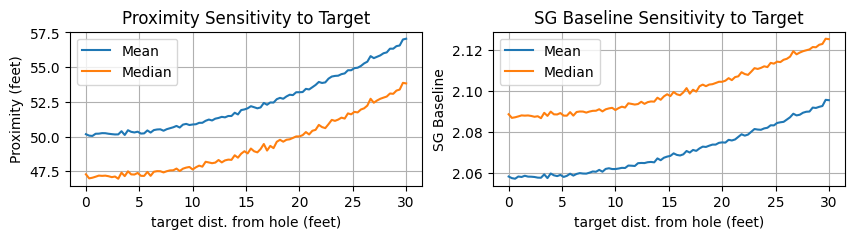

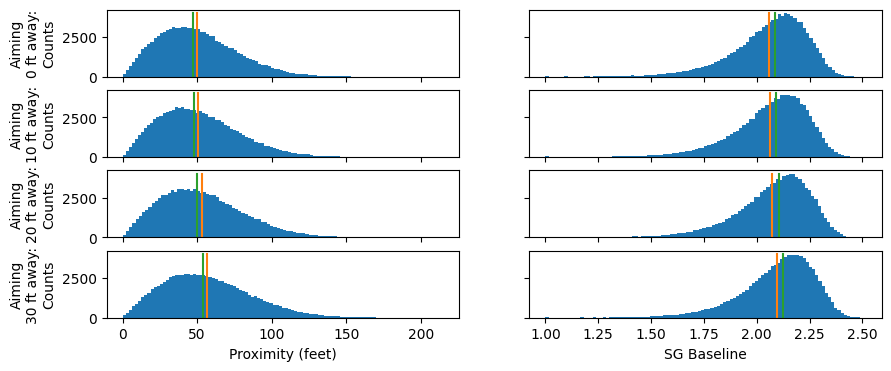

In [9]:
var = 40
expectation_sensitivity(30, var=var)
run_targets(var=var)

# Conclusions

This demonstrates why aiming away from the pin does not necessarily affect your chances of making birdie. In fact, a general pattern is that you can aim an entire standard deviation away, especially from longer distances, and still make nearly as many birdies. You don't see the target shift begin to be the dominating factor in proximity or scoring distributions until the target offset is comparable to the shot pattern, and that is not taking trouble into account.

General idea: if you average 30 ft away from your target with a 9 iron, and you aim 20 ft from the hole, you won't suddenly be hitting it to 50 ft all day. In fact, your average proximity will only go up by a few feet, and you are pretty much just as likely to make birdie.



[P.S.]

I also think this is an interesting case study in probability distributions and their interplay, and how randomness dissolves the observable effects of other factors (including other randomness). If you want to get more into the weeds with this, feel free to reach out, but I think this is already quite dense in information.